# Firstly check the dataset by plotting

Num of points: 42


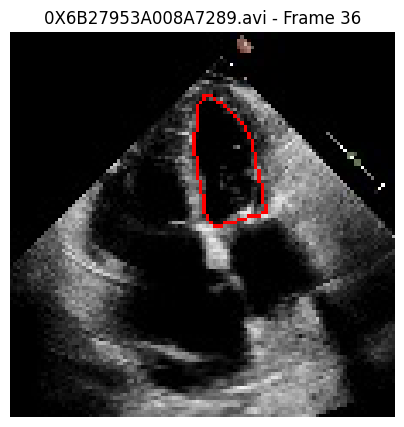

Num of points: 42


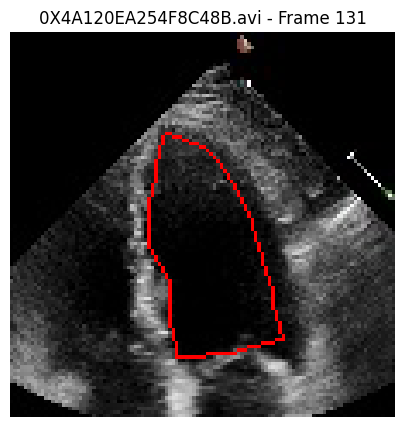

Num of points: 42


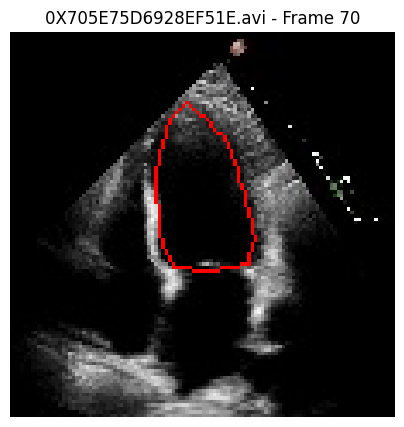

Num of points: 42


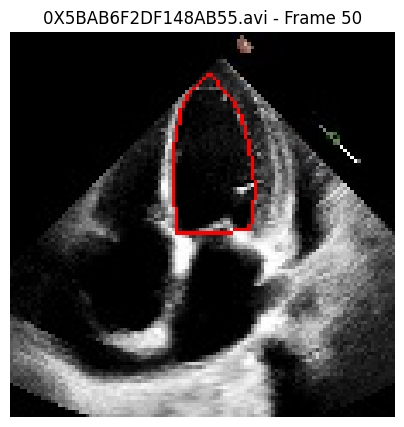

Num of points: 42


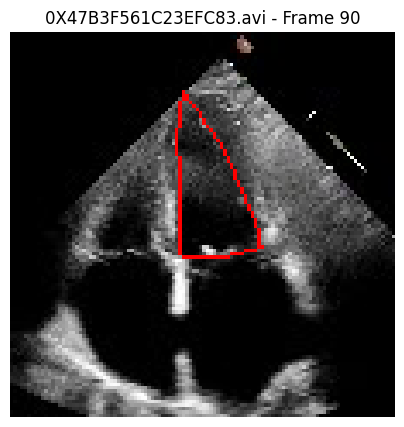

In [8]:
import os
import cv2
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Paths (adjust if needed)
csv_path = "../data/EchoNet-Dynamic/VolumeTracings.csv"
video_dir = "../data/EchoNet-Dynamic/Videos/"  # directory containing .avi files

# Load CSV
df = pd.read_csv(csv_path)

# Group by video name and frame
grouped = df.groupby(["FileName", "Frame"])

# Pick N random (video, frame) pairs
N = 5
random_samples = random.sample(list(grouped.groups.keys()), N)

# Plotting
for i, (filename, frame) in enumerate(random_samples):
    # Load video frame
    video_path = os.path.join(video_dir, filename)
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
    ret, img = cap.read()
    cap.release()
    
    if not ret:
        print(f"Failed to load frame {frame} from {filename}")
        continue
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get all points for this frame
    points = grouped.get_group((filename, frame))[["X1", "Y1", "X2", "Y2"]].values
    # Convert to list of (x, y) points
    polygon_points = []
    for x1, y1, x2, y2 in points:
        polygon_points.append((x1, y1))
    for x1, y1, x2, y2 in reversed(points):
        polygon_points.append((x2, y2))

    # Draw polygon
    print(f'Num of points: {len(polygon_points)}')
    # Combine all keypoints
    points = grouped.get_group((filename, frame))[["X1", "Y1", "X2", "Y2"]].values
    polygon_points = np.vstack([points[:, :2], points[:, 2:]])

    # Calculate centroid
    center = np.mean(polygon_points, axis=0)

    # Sort points based on angle from center
    angles = np.arctan2(polygon_points[:, 1] - center[1], polygon_points[:, 0] - center[0])
    sorted_idx = np.argsort(angles)
    sorted_points = polygon_points[sorted_idx]

    # Convert to integer coordinates
    sorted_points = np.array(sorted_points, dtype=np.int32)

    # Draw polygon
    cv2.polylines(img, [sorted_points], isClosed=True, color=(255, 0, 0), thickness=1)




    # Plot
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"{filename} - Frame {frame}")
    plt.axis("off")
    plt.show()


# Create the datasets for YOLO Pose estimation and the regressor

In [9]:
import os
import cv2
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import numpy as np

In [10]:
# ==== Config ====
MAX_KEYPOINTS = 50
OUTPUT_DIR = Path("../data/yolo_keypoints_dataset")
REGR_CSV_PATH = Path("../data/regressor_dataset.csv")
VIDEO_DIR = Path("../data/EchoNet-Dynamic/Videos")
for split in ['train', 'val', 'test']:
    os.makedirs(OUTPUT_DIR / split / "images", exist_ok=True)
    os.makedirs(OUTPUT_DIR / split / "labels", exist_ok=True)

In [11]:

# ==== Load CSVs ====
filelist_df = pd.read_csv("../data/EchoNet-Dynamic/FileList.csv")
volume_df = pd.read_csv("../data/EchoNet-Dynamic/VolumeTracings.csv")

In [12]:
print(filelist_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10030 entries, 0 to 10029
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FileName        10030 non-null  object 
 1   EF              10030 non-null  float64
 2   ESV             10030 non-null  float64
 3   EDV             10030 non-null  float64
 4   FrameHeight     10030 non-null  int64  
 5   FrameWidth      10030 non-null  int64  
 6   FPS             10030 non-null  int64  
 7   NumberOfFrames  10030 non-null  int64  
 8   Split           10030 non-null  object 
dtypes: float64(3), int64(4), object(2)
memory usage: 705.4+ KB
None


In [13]:
print(volume_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425010 entries, 0 to 425009
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   FileName  425010 non-null  object 
 1   X1        425010 non-null  float64
 2   Y1        425010 non-null  float64
 3   X2        425010 non-null  float64
 4   Y2        425010 non-null  float64
 5   Frame     425010 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 19.5+ MB
None


In [14]:
print("Sample video_id from volume_df:", volume_df['FileName'].iloc[0])
print("Sample VideoBase from volume_df:", volume_df['FileName'].iloc[0].replace('.avi', ''))

print("Sample FileName from filelist_df:", filelist_df['FileName'].iloc[0])


Sample video_id from volume_df: 0X100009310A3BD7FC.avi
Sample VideoBase from volume_df: 0X100009310A3BD7FC
Sample FileName from filelist_df: 0X100009310A3BD7FC


In [15]:
from scipy.interpolate import interp1d

# Preprocessing
filelist_df['FileName'] = filelist_df['FileName'].str.strip()
volume_df['VideoBase'] = volume_df['FileName'].str.replace('.avi', '', regex=False)
volume_df['Frame'] = volume_df['Frame'].astype(int)
grouped = volume_df.groupby(['VideoBase', 'Frame'])

print(f"Total grouped video-frame pairs: {len(grouped)}")

video_frame_areas = {}
regressor_entries = []

for (video_id, frame_num), group in tqdm(grouped, desc="Processing", unit="frame"):
    split_row = filelist_df[filelist_df['FileName'] == f"{video_id}"]
    if split_row.empty:
        print(f"Video ID not found in FileList.csv: {video_id}")
        continue

    split = split_row['Split'].values[0]
    esv = split_row['ESV'].values[0]
    edv = split_row['EDV'].values[0]

    out_img_dir = OUTPUT_DIR / split.lower() / "images"
    out_lbl_dir = OUTPUT_DIR / split.lower() / "labels"
    out_img_dir.mkdir(parents=True, exist_ok=True)
    out_lbl_dir.mkdir(parents=True, exist_ok=True)

    video_path = VIDEO_DIR / f"{video_id}.avi"
    if not video_path.exists():
        print(f"Missing video: {video_path}")
        continue

    # Read frame
    cap = cv2.VideoCapture(str(video_path))
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    ret, frame = cap.read()
    cap.release()
    if not ret:
        print(f"Could not read frame {frame_num} from {video_id}")
        continue
    h, w = frame.shape[:2]

    out_img_path = out_img_dir / f"{video_id}_f{frame_num}.jpg"
    cv2.imwrite(str(out_img_path), frame)

    # Extract and combine points
    points = group[["X1", "Y1", "X2", "Y2"]].values
    polygon_points = np.vstack([points[:, :2], points[:, 2:]]).astype(np.float32)

    # Sort by angle around centroid
    center = np.mean(polygon_points, axis=0)
    angles = np.arctan2(polygon_points[:, 1] - center[1], polygon_points[:, 0] - center[0])
    sorted_idx = np.argsort(angles)
    polygon_points = polygon_points[sorted_idx]

    # Interpolate or truncate to exactly 42 points
    if len(polygon_points) < 42:
        # Interpolate using linear interpolation
        idxs = np.linspace(0, len(polygon_points) - 1, num=42)
        interp_x = interp1d(np.arange(len(polygon_points)), polygon_points[:, 0], kind='linear')(idxs)
        interp_y = interp1d(np.arange(len(polygon_points)), polygon_points[:, 1], kind='linear')(idxs)
        abs_points = np.stack([interp_x, interp_y], axis=-1)
    else:
        abs_points = polygon_points[:42]

    # Area
    area = cv2.contourArea(abs_points.astype(np.int32))
    if video_id not in video_frame_areas:
        video_frame_areas[video_id] = []
    video_frame_areas[video_id].append({
        'frame': frame_num,
        'area': area,
        'esv': esv,
        'edv': edv
    })

    # Normalize for YOLO label
    norm_points = [(x / w, y / h) for x, y in abs_points]
    keypoints_flat = [coord for point in norm_points for coord in point]

    out_lbl_path = out_lbl_dir / f"{video_id}_f{frame_num}.txt"
    with open(out_lbl_path, 'w') as f:
        f.write("0 " + " ".join(f"{kp:.6f}" for kp in keypoints_flat) + "\n")

# Generate regressor dataset from max/min area frames
for video_id, frames in video_frame_areas.items():
    if len(frames) == 0:
        continue
    max_entry = max(frames, key=lambda f: f['area'])
    min_entry = min(frames, key=lambda f: f['area'])

    regressor_entries.append({
        'video_id': video_id,
        'frame_num': max_entry['frame'],
        'area': max_entry['area'],
        'volume_type': 'esv',
        'volume_value': max_entry['esv']
    })
    regressor_entries.append({
        'video_id': video_id,
        'frame_num': min_entry['frame'],
        'area': min_entry['area'],
        'volume_type': 'edv',
        'volume_value': min_entry['edv']
    })

# Save regressor dataset
regressor_df = pd.DataFrame(regressor_entries)
regressor_df.to_csv(REGR_CSV_PATH, index=False)
print(f"Regressor dataset saved to: {REGR_CSV_PATH}")


Total grouped video-frame pairs: 20050


Processing:  53%|█████▎    | 10674/20050 [10:44<08:40, 18.02frame/s] 

Video ID not found in FileList.csv: 0X4F8859C8AB4DA9CB
Video ID not found in FileList.csv: 0X4F8859C8AB4DA9CB


Processing: 100%|██████████| 20050/20050 [21:25<00:00, 15.59frame/s]


Regressor dataset saved to: ../data/regressor_dataset.csv


In [16]:
regressor_df.shape

(20048, 5)

In [17]:
volume_df.head()

,FileName,X1,Y1,X2,Y2,Frame,VideoBase
0,0X100009310A3BD7FC.avi,51.260417,15.348958,64.932292,69.125000,46,0X100009310A3BD7FC
1,0X100009310A3BD7FC.avi,50.037611,17.167841,53.367222,16.321330,46,0X100009310A3BD7FC
2,0X100009310A3BD7FC.avi,49.157378,20.407629,57.090549,18.390722,46,0X100009310A3BD7FC
3,0X100009310A3BD7FC.avi,48.538173,23.581055,59.997339,20.667707,46,0X100009310A3BD7FC
4,0X100009310A3BD7FC.avi,47.918968,26.754480,62.904129,22.944693,46,0X100009310A3BD7FC


In [18]:
# Group by unique frames (VideoBase + Frame)
grouped = volume_df.groupby(["VideoBase", "Frame"])

# Count number of keypoints per frame
keypoints_per_frame = grouped.size()

# Compute stats
min_kp = keypoints_per_frame.min()
max_kp = keypoints_per_frame.max()
mean_kp = keypoints_per_frame.mean()
median_kp = keypoints_per_frame.median()

# Print the stats
print(f"Min keypoints per frame: {min_kp}")
print(f"Max keypoints per frame: {max_kp}")
print(f"Mean keypoints per frame: {mean_kp:.2f}")
print(f"Median keypoints per frame: {median_kp}")

Min keypoints per frame: 16
Max keypoints per frame: 168
Mean keypoints per frame: 21.20
Median keypoints per frame: 21.0


# Check the YOLO Dataset

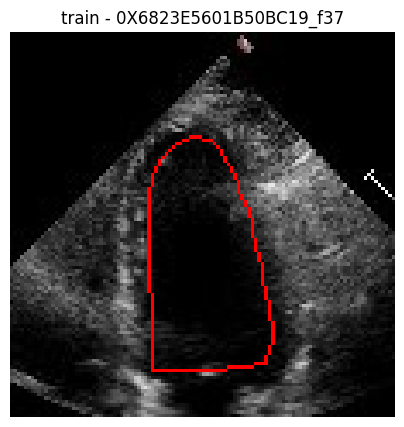

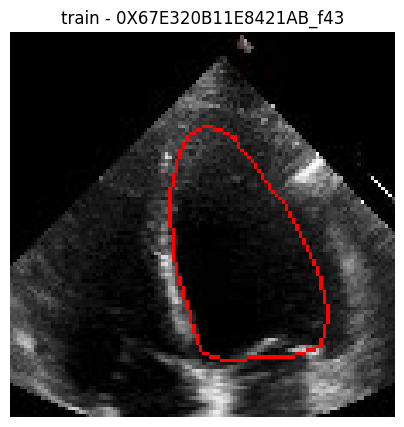

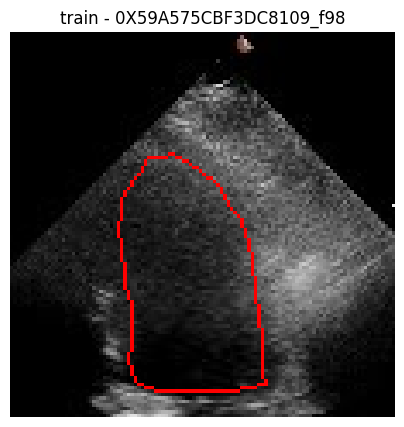

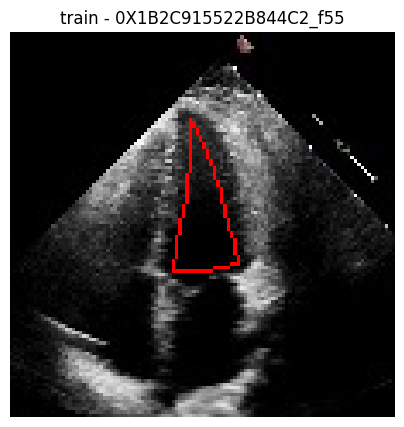

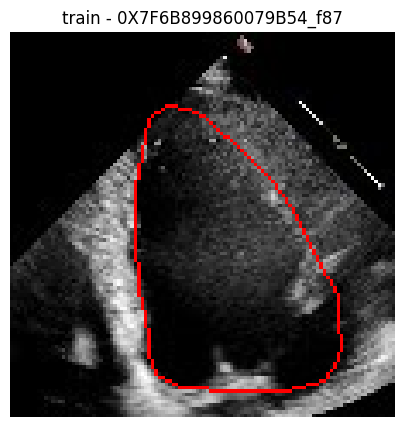

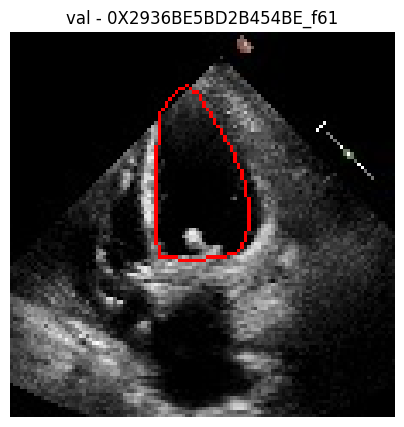

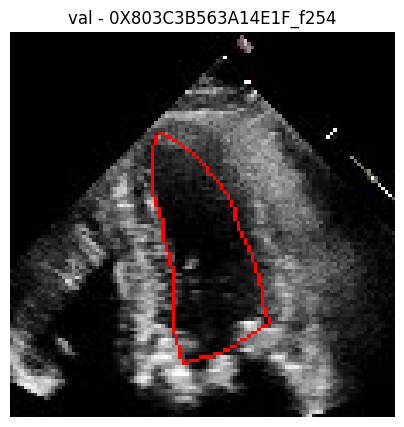

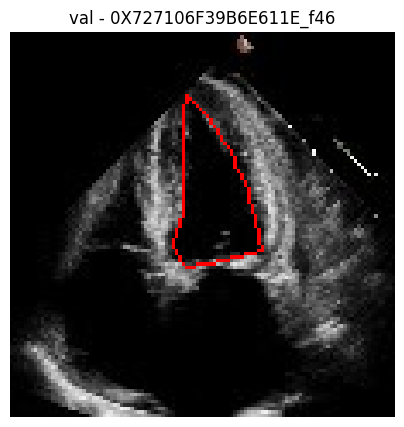

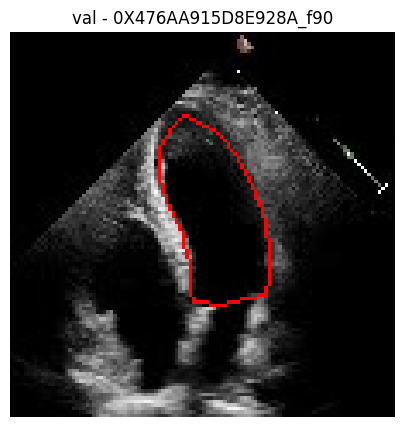

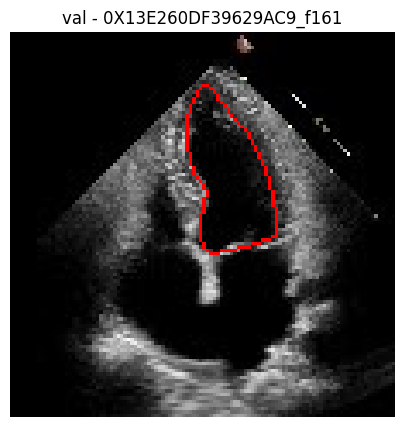

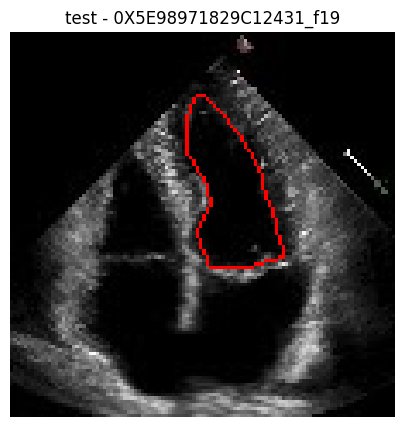

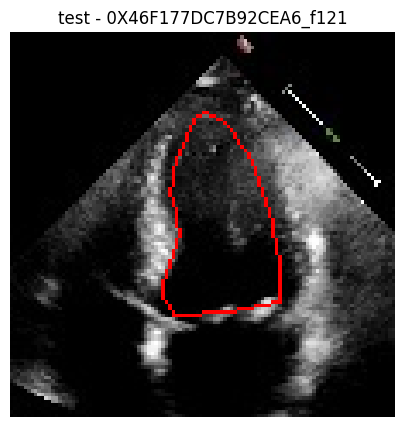

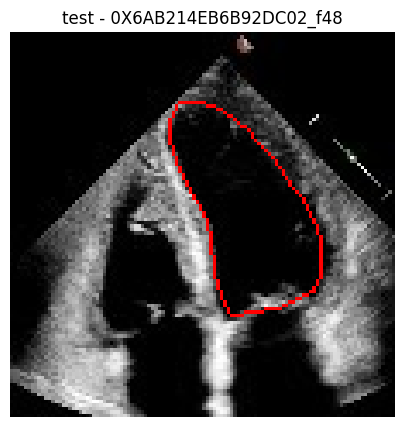

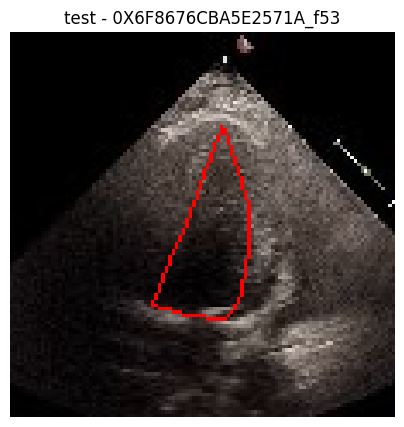

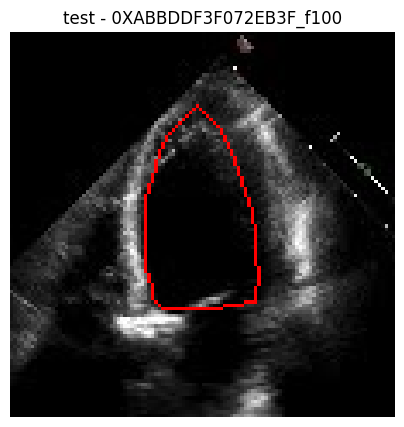

In [26]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Config
YOLO_DATA_DIR = Path("../data/yolo_keypoints_dataset/")  # Structure: train/images, train/labels, etc.
SPLITS = ["train", "val", "test"]
NUM_SAMPLES = 5
MAX_KPTS = 42  # Must match your YOLO label format

for split in SPLITS:
    img_dir = YOLO_DATA_DIR / split / "images"
    lbl_dir = YOLO_DATA_DIR / split / "labels"

    all_images = sorted(list(img_dir.glob("*.jpg")))
    samples = random.sample(all_images, min(NUM_SAMPLES, len(all_images)))

    for img_path in samples:
        label_path = lbl_dir / f"{img_path.stem}.txt"
        if not label_path.exists():
            print(f"Label not found: {label_path}")
            continue

        # Load image
        img = cv2.imread(str(img_path))
        h, w = img.shape[:2]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Read YOLO keypoints from label
        with open(label_path, 'r') as f:
            line = f.readline().strip().split()
            if not line or len(line) < 2 * MAX_KPTS + 1:
                print(f"Incomplete keypoints in {label_path}")
                continue
            keypoints = list(map(float, line[1:]))

        # Reshape and filter valid keypoints
        keypoints = np.array(keypoints).reshape(-1, 2)
        valid_kpts = keypoints[(keypoints[:, 0] >= 0) & (keypoints[:, 1] >= 0)]
        if len(valid_kpts) < 3:
            print(f"Not enough valid keypoints in {label_path}")
            continue

        # Denormalize to image dimensions
        abs_kpts = np.stack([valid_kpts[:, 0] * w, valid_kpts[:, 1] * h], axis=1)

        # Sort points to form polygon
        center = np.mean(abs_kpts, axis=0)
        angles = np.arctan2(abs_kpts[:, 1] - center[1], abs_kpts[:, 0] - center[0])
        sorted_idx = np.argsort(angles)
        sorted_kpts = abs_kpts[sorted_idx].astype(np.int32)

        # Draw polygon
        cv2.polylines(img, [sorted_kpts], isClosed=True, color=(255, 0, 0), thickness=1)

        # Show
        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(f"{split} - {img_path.stem}")
        plt.axis("off")
        plt.show()
